## Make new geometry dataset

In [1]:
from pathlib import Path
import sys as sys
sys.path.append('/Users/mzahn/github_others/simplegrid')
import simplegrid as sg
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xarray as xr

ECCO tutorial that outlines geometry variables is found here: https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Coordinates_and_Dimensions_of_ECCOv4_NetCDF_files.html

Some code here uses pieces of Ian's code available from SASSIE github:
https://github.com/NASA-SASSIE/ECCO/blob/master/SASSIE_utils/sassie_N1_utils.py

In [3]:
## open geometry dataset for LLC90 for reference
geometry_llc90_ds = xr.open_dataset('/Users/mzahn/data/grids/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')

In [4]:
geometry_llc90_ds

<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 ...
    Zu       (k_u) float32 ...
    Zl       (k_l) float32 ...
    XC_bnds  (tile, j, i, nb) float32 ...
    YC_bnds  (tile, j, i, nb) float32 ...
    Z_bnds   (k, nv) float32 ...
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 ...
    SN       (tile, j, i) float32 ...
    rA       (tile, j, i) float32 ...
    dxG      (tile, j_g, i) float32 ...
    dyG      (tile, j, i_g) float32 ...
    Depth    (tile, j, i) float32 ...
    ...       ...
    hFacC    (k, tile, j, i) float32 ...
    hFacW    (k, tile, j, i_g) float32 ...
    hFacS    (k, tile, j_g, i) float32 ...
    maskC    (k, tile, j, i) bool ...
    maskW    (k, tile, j, i_g) bool ...
    maskS    (k, tile, j_g, i) bool ...
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

Open mitgrid files and create dictionary for each geometry variable

In [434]:
N1_geometry_dir = Path('/Users/mzahn/data/grids/grid_sassie/N1_1080/tile_geometry')

## open mitgrid files for each face
t1 = N1_geometry_dir / 'tile001.mitgrid'
t2 = N1_geometry_dir / 'tile002.mitgrid'
t3 = N1_geometry_dir / 'tile003.mitgrid'
t4 = N1_geometry_dir / 'tile004.mitgrid'
t5 = N1_geometry_dir / 'tile005.mitgrid'

## create a dictionary for each face
N1_mg  = dict()
N1_mg[1] = sg.gridio.read_mitgridfile(t1, 1080, 680)
N1_mg[2] = sg.gridio.read_mitgridfile(t2, 1080, 680)
N1_mg[3] = sg.gridio.read_mitgridfile(t3, 1080, 1080)
N1_mg[4] = sg.gridio.read_mitgridfile(t4, 680, 1080)
N1_mg[5] = sg.gridio.read_mitgridfile(t5, 680, 1080)

## see all variables in grid file
print(N1_mg[1].keys())

## create dictionaries for each geometry variable
XC_N1_faces  = dict()
YC_N1_faces  = dict()
XG_N1_faces  = dict()
YG_N1_faces  = dict()
RAC_N1_faces = dict()
DXG_N1_faces = dict()
DYG_N1_faces = dict()
RAZ_N1_faces = dict()
DXC_N1_faces = dict()
DYC_N1_faces = dict()
RAW_N1_faces = dict()
RAS_N1_faces = dict()
DXF_N1_faces = dict()
DYF_N1_faces = dict()
DXV_N1_faces = dict()
DYU_N1_faces = dict()

## loop through each face and extract geometry variable
## transpose each array in order for it to reflect the ECCO map we are familiar with
for face in range(1,6):
    XC_N1_faces[face]  = N1_mg[face]['XC'].T
    YC_N1_faces[face]  = N1_mg[face]['YC'].T
    XG_N1_faces[face]  = N1_mg[face]['XG'].T
    YG_N1_faces[face]  = N1_mg[face]['YG'].T
    RAC_N1_faces[face] = N1_mg[face]['RAC'].T
    DXG_N1_faces[face] = N1_mg[face]['DXG'].T
    DYG_N1_faces[face] = N1_mg[face]['DYG'].T
    RAZ_N1_faces[face] = N1_mg[face]['RAZ'].T
    DXC_N1_faces[face] = N1_mg[face]['DXC'].T
    DYC_N1_faces[face] = N1_mg[face]['DYC'].T
    RAW_N1_faces[face] = N1_mg[face]['RAW'].T
    RAS_N1_faces[face] = N1_mg[face]['RAS'].T
    DXF_N1_faces[face] = N1_mg[face]['DXF'].T
    DYF_N1_faces[face] = N1_mg[face]['DYF'].T
    DXV_N1_faces[face] = N1_mg[face]['DXV'].T
    DYU_N1_faces[face] = N1_mg[face]['DYU'].T

dict_keys(['XC', 'YC', 'DXF', 'DYF', 'RAC', 'XG', 'YG', 'DXV', 'DYU', 'RAZ', 'DXC', 'DYC', 'RAW', 'RAS', 'DXG', 'DYG'])


In [366]:
N1_mg[face]['XG'].T.shape

(1081, 681)

Quick sanity check to see how these files look

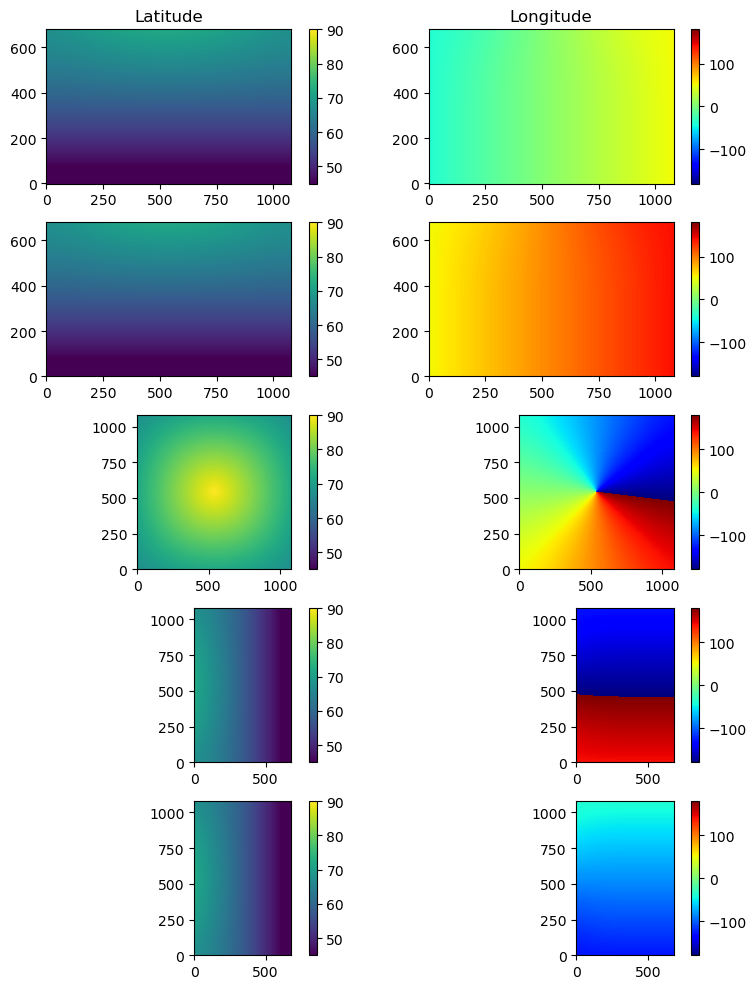

In [9]:
# plot output to inspect files
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10)) = plt.subplots(5,2, figsize=[8,10])

lat = ax1.imshow(YC_N1_faces[1], origin='lower',interpolation='none',vmin=45,vmax=90)
lon = ax2.imshow(XC_N1_faces[1], origin='lower',interpolation='none',cmap='jet',vmin=-180,vmax=180)
fig.colorbar(lat, ax=ax1)
fig.colorbar(lon, ax=ax2)

lat = ax3.imshow(YC_N1_faces[2], origin='lower',interpolation='none',vmin=45,vmax=90)
lon = ax4.imshow(XC_N1_faces[2], origin='lower',interpolation='none',cmap='jet',vmin=-180,vmax=180)
fig.colorbar(lat, ax=ax3)
fig.colorbar(lon, ax=ax4)

lat = ax5.imshow(YC_N1_faces[3], origin='lower',interpolation='none',vmin=45,vmax=90)
lon = ax6.imshow(XC_N1_faces[3], origin='lower',interpolation='none',cmap='jet',vmin=-180,vmax=180)
fig.colorbar(lat, ax=ax5)
fig.colorbar(lon, ax=ax6)

lat = ax7.imshow(YC_N1_faces[4], origin='lower',interpolation='none',vmin=45,vmax=90)
lon = ax8.imshow(XC_N1_faces[4], origin='lower',interpolation='none',cmap='jet',vmin=-180,vmax=180)
fig.colorbar(lat, ax=ax7)
fig.colorbar(lon, ax=ax8)

lat = ax9.imshow(YC_N1_faces[5], origin='lower',interpolation='none',vmin=45,vmax=90)
lon = ax10.imshow(XC_N1_faces[5], origin='lower',interpolation='none',cmap='jet',vmin=-180,vmax=180)
fig.colorbar(lat, ax=ax9)
fig.colorbar(lon, ax=ax10)

ax1.set_title("Latitude")
ax2.set_title("Longitude")

plt.tight_layout()

Function to combine the 5 faces

In [436]:
def combine_sassie_N1_faces(face_arr, num_rotations=2):
    ## create grid of np.nan that we will fill with the individual tile values
    new_arr = np.zeros((680*2+1080, 680*2+1080))*np.nan
    
    # face 1 will be left, center
    start_row = 680
    end_row = start_row + 1080
    start_col = 0
    end_col = start_col + 680
    new_arr[start_row:end_row, start_col:end_col] = np.flipud(face_arr[1].T)

    ## face 2 will be center, bottom
    start_row = 0
    end_row = start_row + 680
    start_col = 680
    end_col = start_col + 1080
    new_arr[start_row:end_row, start_col:end_col] = face_arr[2]
    
    ## face 3 will be in the center (Arctic tile)
    start_row = 680
    end_row = start_row + 1080
    start_col = 680
    end_col = start_col + 1080
    new_arr[start_row:end_row, start_col:end_col] = face_arr[3]
    
    ## face 4 will be on the right, center
    start_row = 680
    end_row = start_row + 1080
    start_col = 680 + 1080
    end_col = start_col + 680
    new_arr[start_row:end_row, start_col:end_col] = face_arr[4]
    
    ## face 5 will be center, top
    start_row = 680 + 1080
    end_row = start_row + 680
    start_col = 680
    end_col = start_col + 1080
    new_arr[start_row:end_row, start_col:end_col] = np.fliplr(face_arr[5].T) # rotate 90 to the left

    return np.rot90(new_arr,num_rotations)

Function to plot the combined file to ensure it worked

In [438]:
def plot_sassie_N1_faces_combined(face_arr, num_rotations=2,\
    hs='X', facecolor='grey', vmin=-1,vmax=1, cmap='jet',\
    show_colorbar=True, axs = None):

    tmp = combine_sassie_N1_faces(face_arr, num_rotations=num_rotations)

    if axs == None:
        h = plt.imshow(tmp, origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        if show_colorbar:
            plt.colorbar()
        axs = plt.gca()
    else:
        h = axs.imshow(tmp, origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        fig = plt.gcf()
        if show_colorbar:
            fig.colorbar(h, ax=axs)

    axs.add_patch( Rectangle((0, 0), 681,681, hatch=hs, facecolor=facecolor))
    axs.add_patch( Rectangle((680+1080, 1080+680), 681,681,hatch=hs, facecolor=facecolor))
    axs.add_patch( Rectangle((0, 1080+680), 681,681, hatch=hs, facecolor=facecolor))
    axs.add_patch( Rectangle((1080+680,0), 681,681, hatch=hs, facecolor=facecolor))

    return axs, tmp, h

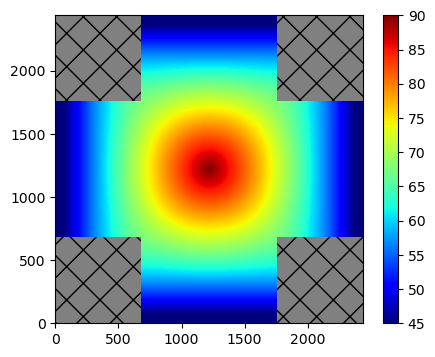

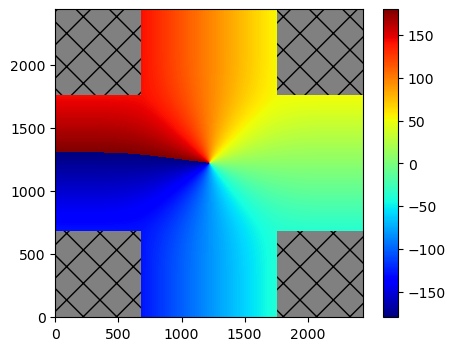

In [213]:
plt.figure(figsize=[5,4]);
tmpA = plot_sassie_N1_faces_combined(YC_N1_faces,vmin=45,vmax=90);
plt.figure(figsize=[5,4]);
tmpB = plot_sassie_N1_faces_combined(XC_N1_faces,vmin=-180,vmax=180);

With this orientation, Alaska is in the dark blue section of the bottom plot (in the lower left portion of the map where we want it for HHv2)

## Create coordinates for geometry dataset

#### index coords

These index coordinates serve as dimensional coordinates in the geometry dataset. They are all integers and have the same name as their corresponding dimensions.

In [16]:
i_array = np.arange(1800)
i_g_array = np.arange(1800)

j_array = np.arange(1080)
j_g_array = np.arange(1080)

k_array = np.arange(90)
k_u_array = np.arange(90)
k_l_array = np.arange(90)
k_p1_array = np.arange(91)

#### depth coords

Convention is negative downwards (i.e., depths are negative)

In [20]:
## array of grid cell thickness
delR = np.array([1.00, 1.14, 1.30, 1.49, 1.70,
                 1.93, 2.20, 2.50, 2.84, 3.21,
                 3.63, 4.10, 4.61, 5.18, 5.79,
                 6.47, 7.20, 7.98, 8.83, 9.73,
                 10.69, 11.70, 12.76, 13.87, 15.03,
                 16.22, 17.45, 18.70, 19.97, 21.27,
                 22.56, 23.87, 25.17, 26.46, 27.74,
                 29.00, 30.24, 31.45, 32.65, 33.82,
                 34.97, 36.09, 37.20, 38.29, 39.37,
                 40.45, 41.53, 42.62, 43.73, 44.87,
                 46.05, 47.28, 48.56, 49.93, 51.38,
                 52.93, 54.61, 56.42, 58.38, 60.53,
                 62.87, 65.43, 68.24, 71.33, 74.73,
                 78.47, 82.61, 87.17, 92.21, 97.79,
                 103.96, 110.79, 118.35, 126.73, 136.01,
                 146.30, 157.71, 170.35, 184.37, 199.89,
                 217.09, 236.13, 257.21, 280.50, 306.24,
                 334.64, 365.93, 400.38, 438.23, 479.74])

In [22]:
## Z bottom
Zu = (np.cumsum(delR))*-1 # k_u is corresponding dimension
print(len(Zu))

## Z top
Zl = np.concatenate([np.array([0]), Zu[:-1]]) # k_l is corresponding dimension
print(len(Zu))

## Z center (convention is negative downwards)
Z = (Zu + Zl) / 2 # k is corresponding dimension
print(len(Z))

## depths of grid cell interface (includes top and bottom of surface and deepest grid cell, respectively)
Zp1 = np.concatenate([np.array([0]), Zu]) # k_p1 is corresponding dimension
print(len(Zp1))

## bounds of upper and lower depths for each grid cell (one pair for each vertical level)
Z_bnds = []
for i in range(len(Z)):
    Z_pair_tmp = [Zl[i], Zu[i]] # upper, lower
    Z_bnds.append(Z_pair_tmp)
Z_bnds = np.array(Z_bnds)
Z_bnds.shape

90
90
90
91


(90, 2)

#### X and Y coords

In [24]:
def combine_sassie_N1_faces_to_HHv2(face_arr):
    ## create empty array of zeros with shape for HHv2
    new_arr = np.zeros((1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:, 185:185+1080] = face_arr[3]
    
    ## add part of face 1 (Europe)
    new_arr[:, 0:185] = np.flipud(face_arr[1][-185:,:].T)
    
    ## add part of face 4 (Alaska)
    new_arr[:, 185+1080:] = face_arr[4][:,:535]
    
    ## rotate by 90 deg twice to have Alaska on bottom left
    new_arr = np.rot90(new_arr,2)
    
    return new_arr

In [26]:
def plot_sassie_N1_faces_HHv2(face_arr, vmin=None, vmax=None,\
    cmap='jet', axs = None, \
    show_colorbar=True):

    tmp = combine_sassie_N1_faces_to_HHv2(face_arr)

    if vmin == None:
        vmin = np.min(tmp)
    if vmax == None:
        vmax = np.max(tmp)

    if axs == None:
        plt.imshow(tmp, origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        if show_colorbar:
            plt.colorbar()

    else:
        im1 = axs.imshow(tmp, origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        fig = plt.gcf()
        if show_colorbar:
            fig.colorbar(im1, ax=axs)

In [28]:
## run function for each geometry variable
XC_HHv2  = combine_sassie_N1_faces_to_HHv2(XC_N1_faces) # longitude of tracer grid cell center
YC_HHv2  = combine_sassie_N1_faces_to_HHv2(YC_N1_faces) # latitude of tracer grid cell center

Double check to make sure it looks right using lat/lon

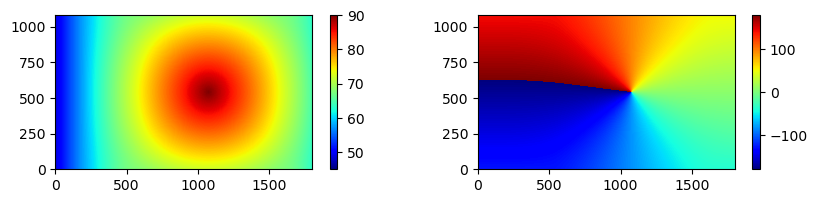

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=[10,2])
plot_sassie_N1_faces_HHv2(YC_N1_faces,vmin=45,vmax=90, axs=ax1)
plot_sassie_N1_faces_HHv2(XC_N1_faces,vmin=-180,vmax=180, axs=ax2)

## Create data variables for geometry dataset

#### Functions

In [30]:
## function from ecco documentation
def load_binary_array(fdir, fname, ni, nj, nk=1, nl=1, skip=0,
                      filetype = '>f', less_output = False ):
    """
    Note: This function is for reading a general binary file. To read data in
    the llc structure, see read_bin_llc.

    Loads a binary array from a file into memory, which is not necessarily in
    llc format.  The first two dimensions
    of the array have length ni and nj, respectively.  The array is comprised
    of one or more 2D 'slices' of dimension ni x nj.  The number of 2D slices
    to read is 'nk'.  nk is not necessarily the length of the third dimension
    of the file.  The 'skip' parameter specifies the number of 2D slices
    to skip over before reading the nk number of 2D slices.  nk can be 1.

    Parameters
    ----------
    fdir : string
        A string with the directory of the binary file to open
    fname : string
        A string with the name of the binary file to open
    ni,nj : int
        the length of each array dimension.  ni, nj must be > 0
    skip : int
        the number of 2D (nj x ni) slices to skip.
        Default: 0
    nk : int
        number of 2D slices (or records) to load in the third dimension.
        if nk = -1, load all 2D slices
        Default: 1 [singleton]
    nl : int
        number of 2D slices (or records) to load in the fourth dimension.
        Default: 1 [singleton]
    filetype: string
        the file type, default is big endian (>) 32 bit float (f)
        alternatively, ('<d') would be little endian (<) 64 bit float (d)
        Default '>f'
    less_output : boolean
        A debugging flag.  False = less debugging output
        Default: False

    Returns
    -------
    data
        a numpy array with dimensions nl x nk x nj x ni

    Raises
    ------
    IOError
        If the file is not found

    """
    #datafile = fdir + '/' + fname
    data_folder = Path(fdir)
    datafile = data_folder / fname

    #datafile = os.path.join(fdir, fname)
    if not less_output:
        print('load_binary_array: loading file', datafile)

    # check to see if file exists.
    if datafile.exists() == False:
        raise IOError(fname + ' not found ')

    f = open(datafile, 'rb')
    dt = np.dtype(filetype)

    if skip > 0:
        # skip ahead 'skip' number of 2D slices
        f.seek(ni*nj*skip*dt.itemsize)

    if (ni <= 0) or (nj <= 0):
        raise TypeError('ni and nj must be > 1')

    # load all 2D records
    if nk == -1:
        # nl can only be 1 if we use nk = -1
        nl = 1
        # read all 2D records
        arr_k = np.fromfile(f, dtype=filetype, count=-1)
        # find the number of 2D records (nk)
        length_arr_k = len(arr_k)

        # length of each 2D slice is ni * nj
        nk = int(length_arr_k / (ni*nj))

        if not less_output:
            print('load_binary_array: loading all 2D records.  nk =',nk)

        # reshape the array to 2D records
        if nk > 1: # we have more than one 2D record, make 3D field
            data = np.reshape(arr_k,(nk, nj, ni))

        else: # nk = 1, just make 2D field
            data = np.reshape(arr_k,(nj, ni))

    # read a specific number of records (nk*nl)
    else:
        if (nk <= 0) or (nl <= 0):
            raise TypeError('nk and nl must be > 0.  If they are singleton dimensions, use 1')

        # read in nk*nl 2D records
        arr_k = np.fromfile(f, dtype=filetype, count=ni*nj*nk*nl)

        # put data into 2D records
        #  - if we have a fourth dimension
        if nl > 1:
            data = np.reshape(arr_k,(nl, nk, nj, ni))

        #  - if we have a third dimension
        elif nk > 1:
            data = np.reshape(arr_k,(nk, nj, ni))

        #  - if we only have two dimensions
        else:
            data = np.reshape(arr_k,(nj, ni))

    f.close()

    if not less_output:
        print('load_binary_array: data array shape ', data.shape)
        print('load_binary_array: data array type ', data.dtype)

    return data

In [32]:
def load_sassie_N1_field(file_dir, fname, nk):
    num_cols = 680*4 + 1080
    num_rows = 1080
    
    tmp_compact = load_binary_array(file_dir, fname, \
                                    num_rows, num_cols, nk, filetype='>f4')

    return tmp_compact

In [34]:
def sassie_n1_compact_to_faces(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n
    sassie_faces[2] = sassie_n1_compact[start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    return sassie_faces

In [131]:
## function to slice small pieces from Faces 1 and 4 and combine them to the Arctic Face 3
def combine_sassie_N1_faces_to_HHv2(face_arr):
    ## for variables that have length equal to N+1, we only need N so we remove the last observation for the face
    if face_arr[3].shape == (1081,1081):
        face_arr[1] = face_arr[1][:-1,:-1]
        face_arr[3] = face_arr[3][:-1,:-1]
        face_arr[4] = face_arr[4][:-1,:-1]
    
    # dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800)) 
    # cut out sections we want and assign them to location on HH
    new_arr[:, 185:185 + 1080] = face_arr[3]
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, 0:185] = np.flipud(face_arr[1][-185:,:].T) # flip and transpose
    new_arr[:, 185 + 1080:] = face_arr[4][:,:535]

    new_arr = np.rot90(new_arr,2) # rotate it 180 so Greenland/AK are on bottom
    return new_arr

#### CS and SN

CS: cosine of tracer grid cell orientation vs geographical north<br>
SN: sine of tracer grid cell orientation vs geographical north<br>

with the convention that rotating counterclockwise gives a negative angle

Run functions

In [38]:
angle_dir = Path('/Users/mzahn/data/SASSIE/input')

angleCS_compact = load_sassie_N1_field(angle_dir, 'AngleCS.data', nk=1)
angleSN_compact = load_sassie_N1_field(angle_dir, 'AngleSN.data', nk=1)

load_binary_array: loading file /Users/mzahn/data/SASSIE/input/AngleCS.data
load_binary_array: data array shape  (3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/input/AngleSN.data
load_binary_array: data array shape  (3800, 1080)
load_binary_array: data array type  >f4


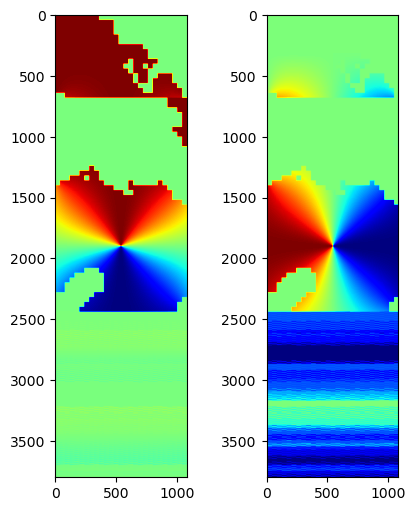

In [40]:
fig,axs = plt.subplots(1,2, figsize=[5,6])
axs[0].imshow(angleCS_compact[:,:], origin='lower', cmap='jet')
axs[1].imshow(angleSN_compact[:,:], origin='lower', cmap='jet')

for ax in axs:
    ax.invert_yaxis()

In [42]:
angleCS_faces = sassie_n1_compact_to_faces(angleCS_compact)
angleSN_faces = sassie_n1_compact_to_faces(angleSN_compact)

angleCS_faces_HHv2 = combine_sassie_N1_faces_to_HHv2(angleCS_faces)
angleSN_faces_HHv2 = combine_sassie_N1_faces_to_HHv2(angleSN_faces)

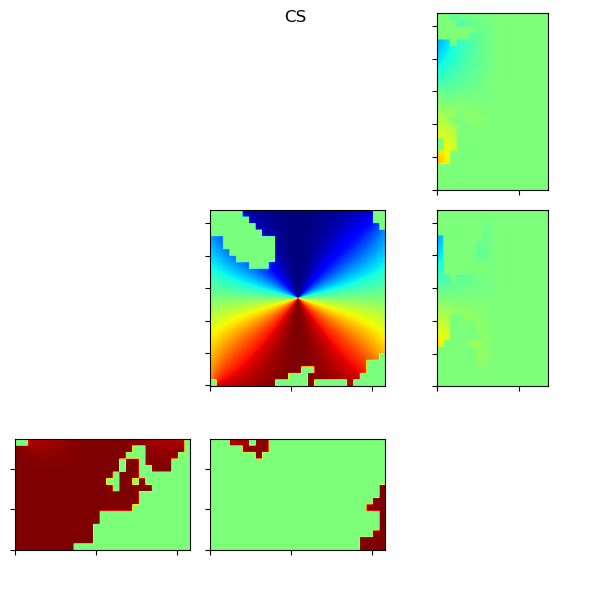

In [484]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(angleCS_faces[5], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[3].set_axis_off()
ax[4].imshow(angleCS_faces[3], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[5].imshow(angleCS_faces[4], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[6].imshow(angleCS_faces[1], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[7].imshow(angleCS_faces[2], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.tight_layout()
plt.suptitle("CS");

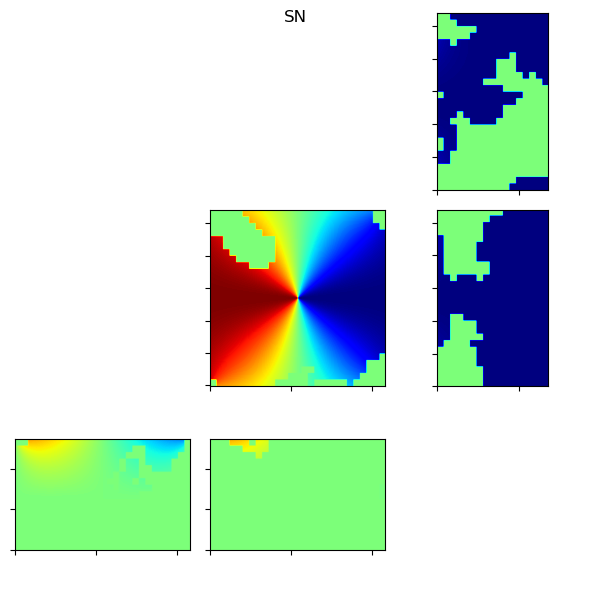

In [488]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(angleSN_faces[5], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[3].set_axis_off()
ax[4].imshow(angleSN_faces[3], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[5].imshow(angleSN_faces[4], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[6].imshow(angleSN_faces[1], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[7].imshow(angleSN_faces[2], origin='lower', cmap='jet', vmin=-1, vmax=1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.tight_layout()
plt.suptitle("SN");

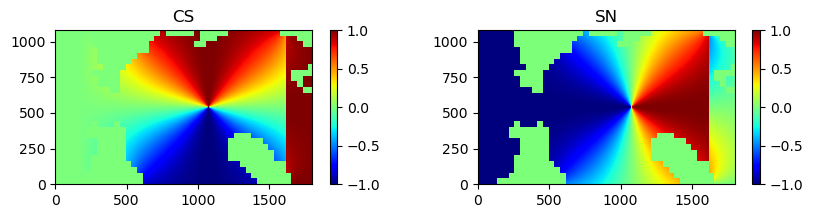

In [486]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=[10,2])
plot_sassie_N1_faces_HHv2(angleCS_faces,vmin=-1,vmax=1, axs=ax1)
plot_sassie_N1_faces_HHv2(angleSN_faces,vmin=-1,vmax=1, axs=ax2)
ax1.set_title('CS')
ax2.set_title('SN');

**Need to multiple everything by -1 because we rotated the entire fieldby 180 degrees so that Greenland is on bottom right and Bering Strait is on the left**

**We also need to swap tile 1 between CS and SN**

In [44]:
def combine_sassie_N1_faces_to_HHv2_angles(angleCS_faces, angleSN_faces):
    ## create empty arrays of zeros with shape for HHv2
    angleCS_faces_HHv2 = np.zeros((1080, 1800))
    angleSN_faces_HHv2 = np.zeros((1080, 1800))
    
    ## add Arctic face (3)
    angleCS_faces_HHv2[:, 185:185+1080] = angleCS_faces[3]
    angleSN_faces_HHv2[:, 185:185+1080] = angleSN_faces[3]
    
    ## add part of face 1 (Europe)
    ## need to swap CS and SN
    angleCS_faces_HHv2[:, 0:185] = np.flipud(angleSN_faces[1][-185:,:].T)*-1
    angleSN_faces_HHv2[:, 0:185] = np.flipud(angleCS_faces[1][-185:,:].T)
    
    ## add part of face 4 (Alaska)
    angleCS_faces_HHv2[:, 185+1080:] = angleCS_faces[4][:,:535]
    angleSN_faces_HHv2[:, 185+1080:] = angleSN_faces[4][:,:535]
    
    ## rotate by 90 deg twice to have Alaska on bottom left
    ## multiply everything by negative 1 to reflect this rotation
    angleCS_faces_HHv2 = (np.rot90(angleCS_faces_HHv2,2))*-1
    angleSN_faces_HHv2 = (np.rot90(angleSN_faces_HHv2,2))*-1
    
    return angleCS_faces_HHv2, angleSN_faces_HHv2

In [46]:
angleCS_faces = sassie_n1_compact_to_faces(angleCS_compact)
angleSN_faces = sassie_n1_compact_to_faces(angleSN_compact)

angleCS_faces_HHv2, angleSN_faces_HHv2 = combine_sassie_N1_faces_to_HHv2_angles(angleCS_faces, angleSN_faces)

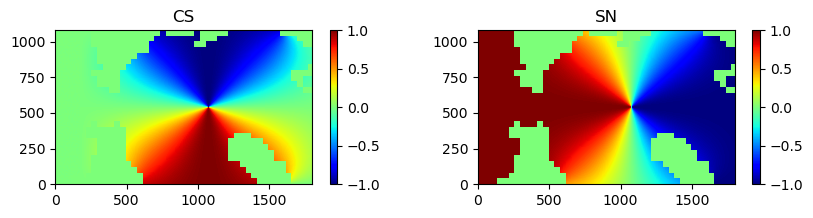

In [529]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=[10,2])
ax1_cb = ax1.imshow(angleCS_faces_HHv2,vmin=-1,vmax=1,interpolation='none',origin='lower',cmap='jet')
fig = plt.gcf()
fig.colorbar(ax1_cb)
ax2_cb = ax2.imshow(angleSN_faces_HHv2,vmin=-1,vmax=1,interpolation='none',origin='lower',cmap='jet')
fig = plt.gcf()
fig.colorbar(ax2_cb)
ax1.set_title('CS')
ax2.set_title('SN');

#### RAC: area of tracer grid cell

In [192]:
RAC_HHv2 = combine_sassie_N1_faces_to_HHv2(RAC_N1_faces)
RAC_HHv2.shape

(1080, 1800)

#### k variables: drF, drC, PHrefC, PHrefF

In [230]:
# drF: distance between the upper and lower interfaces of the model grid cell in meters
drF_HHv2 = delR # cell thickness in meters
drF_HHv2.shape

(90,)

In [343]:
# distance between the centers of adjacent tracer grid cells in the 'z' direction
# The first element corresponds to the distance between the depth of the center of the uppermost model grid cell and the surfacesurf
surf = [Z[0]*-1] # distance between surface and middle of uppermost grid cell
middle = np.diff(Z*-1) # difference between center of grid cells
bottom = [(Zu[-1] - Z[-1])*-1] # distance between bottom and middle of lowermost grid cell

drC_HHv2 = np.concatenate([surf, middle, bottom])

drC_HHv2.shape # check dimensions

In [226]:
print(geometry_llc90_ds.PHrefC.long_name, '\n')
print(geometry_llc90_ds.PHrefC.comment)

reference ocean hydrostatic pressure at tracer grid cell center 

PHrefC = p_ref (k) / rhoConst = rhoConst g z(k) / rhoConst = g z(k), where p_ref(k) is reference hydrostatic ocean pressure at center of tracer grid cell k, rhoConst is reference density (1029 kg m-3), g is acceleration due to gravity (9.81 m s-2), and z(k) is depth at center of tracer grid cell k. Units: p:[kg m-1 s-2], rhoConst:[kg m-3], g:[m s-2], z_m(t):[m]. Note: does not include atmospheric pressure loading. Quantity referred to in some contexts as hydrostatic pressure potential. PHIHYDcR is anomaly of PHrefC.


In [228]:
print(geometry_llc90_ds.PHrefF.long_name, '\n')
print(geometry_llc90_ds.PHrefF.comment)

reference ocean hydrostatic pressure at tracer grid cell top/bottom interface 

PHrefF = p_ref (k_l) / rhoConst = rhoConst g z(k_l) / rhoConst = g z(k_l), where p_ref(k_l) is reference hydrostatic ocean pressure at lower interface of tracer grid cell k, rhoConst is reference density (1029 kg m-3), g is acceleration due to gravity (9.81 m s-2), and z(k) is depth at center of tracer grid cell k. Units: p:[kg m-1 s-2], rhoConst:[kg m-3], g:[m s-2], z_m(t):[m]. Note: does not include atmospheric pressure loading. Quantity referred to in some contexts as hydrostatic pressure potential. See PHrefC


### XG, YG, XC_bnds, and YC_bnds

XG and YG have length N+1: (681, 1081) or (1081, 681) or (1081,1081)

In [93]:
print(XG_N1_faces[1][-1,-1] == XG_N1_faces[3][0,0])
print(XG_N1_faces[1][-1,0] == XG_N1_faces[3][-1,0])

True
True


In [95]:
print(YG_N1_faces[1][-1,-1] == YG_N1_faces[3][0,0])
print(YG_N1_faces[1][-1,0] == YG_N1_faces[3][-1,0])

True
False


In [133]:
XG_HHv2 = combine_sassie_N1_faces_to_HHv2(XG_N1_faces)
YG_HHv2 = combine_sassie_N1_faces_to_HHv2(YG_N1_faces)

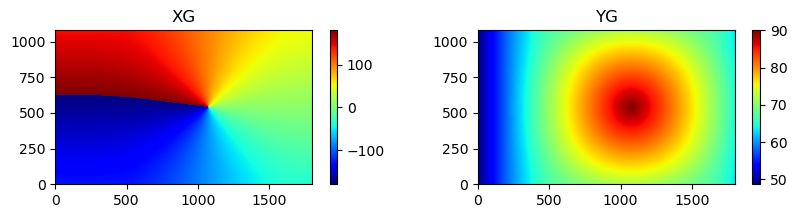

In [135]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=[10,2])
ax1_cb = ax1.imshow(XG_HHv2,interpolation='none',origin='lower',cmap='jet')
fig = plt.gcf()
fig.colorbar(ax1_cb)
ax2_cb = ax2.imshow(YG_HHv2,interpolation='none',origin='lower',cmap='jet')
fig = plt.gcf()
fig.colorbar(ax2_cb)
ax1.set_title('XG')
ax2.set_title('YG');

In [391]:
def XC_and_YC_bnds(XG_YG_N1_face):
    """
    Creates a new array for latitudes/longitudes of tracer grid cell corners.
    
    `XG_YG_N1_face` is a single face for either XG or YG (e.g., XG_N1_faces[1])
    `XX_bnds` is either the XC_bnds or YC_bnds
    """
        
    XX_bnds = []
    for j in range(len(XG_YG_N1_face[:,0])-1):
        rows_tmp = XG_YG_N1_face[j:j+2,:] # take two rows at a time
        
        ## loop through each element from that row
        row_bnds_tmp = []
        
        for i in range(len(rows_tmp[0,:])-1):
            sw = rows_tmp[0,i] # 'southwest'
            se = rows_tmp[0,i+1] # 'southeast'
            ne = rows_tmp[1,i+1] # 'northeast'
            nw = rows_tmp[1,i] # 'northwest'
            
            row_bnds_tmp.append([sw, se, ne, nw])
            
        XX_bnds.append(row_bnds_tmp)
        
    XX_bnds = np.array(XX_bnds)
    return XX_bnds

In [393]:
XG_face = geometry_llc90_ds.isel(tile=0).XG
XC_bnds = XC_and_YC_bnds(XG_face)

In [395]:
# do a test with the existing dataset to double check loop works properly
np.all(geometry_llc90_ds.isel(tile=0).XC_bnds[0].values[:-1,:] == XC_bnds[0])

True

Run the function for the three faces used in HHv2

In [531]:
## function to slice small pieces from Faces 1 and 4 and combine them to the Arctic Face 3
def combine_sassie_N1_faces_to_HHv2_XX_bnds(face_arr):
    ## run function to extract 4 corners of each tracer grid cell
    face_arr_1 = XC_and_YC_bnds(face_arr[1])
    face_arr_3 = XC_and_YC_bnds(face_arr[3])
    face_arr_4 = XC_and_YC_bnds(face_arr[4])
    
    # dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800, 4)) 
    # cut out sections we want and assign them to location on HH
    new_arr[:, 185:185 + 1080, :] = face_arr_3
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, 0:185, :] = np.transpose(face_arr_1[-185:,::-1,:],axes=(1,0,2)).reshape(1080,185,4)
    new_arr[:, 185 + 1080:, :] = face_arr_4[:,:535,:]

    new_arr = np.rot90(new_arr,2) # rotate it 180 so Greenland/AK are on bottom
    return new_arr

In [533]:
XC_bnds_HHv2 = combine_sassie_N1_faces_to_HHv2_XX_bnds(XG_N1_faces)

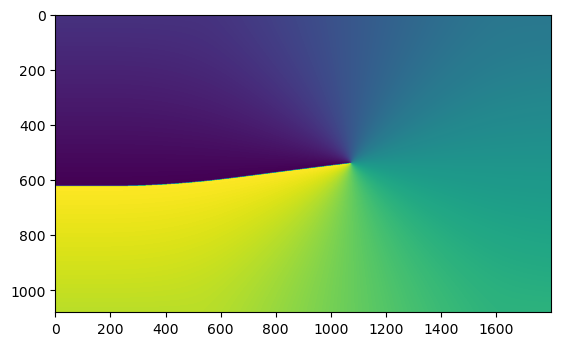

In [534]:
plt.imshow(XC_bnds_HHv2[:,:,0])

### HHv2 for u points

In [ ]:
def combine_sassie_N1_faces_to_HHv2_u_point(face_arr_u, face_arr_v, vec=False):
    new_arr = np.zeros((1080, 1441))
    #[181 + 1080 + 180]
    #[u_n+1 .. u_0  + u_n ... u_0 + v_n .. v_n-180]
    new_arr[:, 180:180+1080] = face_arr_u[3]
    new_arr[:, 0:180] = np.flipud(face_arr_v[1][-180:,:].T)
    new_arr[:, 180+1080:] = face_arr_u[4][:,:181]

    new_arr = np.rot90(new_arr,2)
    if vec:
        new_arr = new_arr *-1
    return new_arr

In [95]:

# DXG_HHv2 = combine_sassie_N1_faces_to_HHv2(DXG_N1_faces)
# DYG_HHv2 = combine_sassie_N1_faces_to_HHv2(DYG_N1_faces)
# RAZ_HHv2 = combine_sassie_N1_faces_to_HHv2(RAZ_N1_faces)
# DXC_HHv2 = combine_sassie_N1_faces_to_HHv2(DXC_N1_faces)
# DYC_HHv2 = combine_sassie_N1_faces_to_HHv2(DYC_N1_faces)
# RAW_HHv2 = combine_sassie_N1_faces_to_HHv2(RAW_N1_faces)
# RAS_HHv2 = combine_sassie_N1_faces_to_HHv2(RAS_N1_faces)
# DXF_HHv2 = combine_sassie_N1_faces_to_HHv2(DXF_N1_faces)
# DYF_HHv2 = combine_sassie_N1_faces_to_HHv2(DYF_N1_faces)
# DXV_HHv2 = combine_sassie_N1_faces_to_HHv2(DXV_N1_faces)
# DYU_HHv2 = combine_sassie_N1_faces_to_HHv2(DYU_N1_faces)

In [ ]:
DYG_HH = su.combine_sassie_N1_faces_to_HH_u_point(DYG_N1_faces, DXG_N1_faces)

Isolate HHv2 for 3D fields

In [ ]:
DYG_HH = su.combine_sassie_N1_faces_to_HH_u_point(DYG_N1_faces, DXG_N1_faces)

plt.figure(figsize=[8,4])
su.plot_sassie_N1_faces_HH(YC_N1_faces)

plt.figure(figsize=[8,4])
su.plot_sassie_N1_faces_HH(XC_N1_faces)

In [14]:
hFacDir = Path('/home/ifenty/data/grids/grid_sassie/N1_1080/hfac/')
print(list(hFacDir.glob('*')))
hFacFile = 'hFacC.data'

num_cols = 680*4 + 1080
num_rows = 1080

filename = hFacFile

hFacC_N1_compact =\
    ecco.load_binary_array(hFacDir, filename, \
                           num_rows, num_cols, nk_N1, filetype='>f4')

hFacC_N1_faces    = su.sassie_n1_compact_to_faces_3D(hFacC_N1_compact)

maskC_N1_compact = np.where(hFacC_N1_compact > 0, 1, 0);
maskC_nan_N1_compact = np.where(hFacC_N1_compact > 0, 1, np.nan);
maskC_nan_N1_compact.shape
maskC_nan_N1_faces = su.sassie_n1_compact_to_faces_3D(maskC_nan_N1_compact)

[PosixPath('/home/ifenty/data/grids/grid_sassie/N1_1080/hfac/hFacW.meta'), PosixPath('/home/ifenty/data/grids/grid_sassie/N1_1080/hfac/hFacC.data'), PosixPath('/home/ifenty/data/grids/grid_sassie/N1_1080/hfac/hFacC.meta'), PosixPath('/home/ifenty/data/grids/grid_sassie/N1_1080/hfac/hFacS.data'), PosixPath('/home/ifenty/data/grids/grid_sassie/N1_1080/hfac/hFacW.data'), PosixPath('/home/ifenty/data/grids/grid_sassie/N1_1080/hfac/hFacS.meta')]
load_binary_array: loading file /home/ifenty/data/grids/grid_sassie/N1_1080/hfac/hFacC.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4


Text(0.5, 1.0, 'k=20   88.175m')

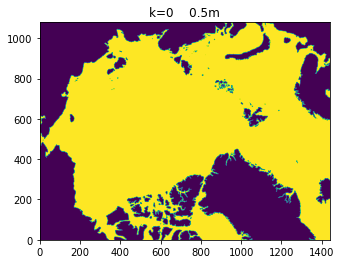

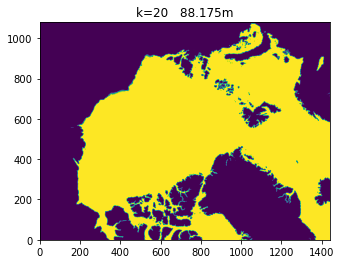

In [16]:
hFacC_N1_HH = su.combine_sassie_N1_faces_to_HH_3D(hFacC_N1_faces)
plt.figure();
plt.imshow(hFacC_N1_HH[0,:], origin='lower');plt.title('k=0    ' + str(Z_N1[0]) + 'm')
plt.figure();
plt.imshow(hFacC_N1_HH[20,:], origin='lower');plt.title('k=20   ' + str(Z_N1[20]) + 'm')

In [17]:
maskC_HH = np.where(hFacC_N1_HH > 0, 1, 0)

In [18]:
hFacC_HH_da = make_3D_HH_da(hFacC_N1_HH, 'hFacC')
hFacC_HH_da.attrs['description'] = 'fraction of grid height that is wet'

mask_HH_da = make_3D_HH_da(maskC_HH, 'maskC')
mask_HH_da.attrs['description'] = 'wet/dry mask   land = 0, wet = 1'

RAC_HH_da = make_2D_HH_da(RAC_HH, 'RAC')
RAC_HH_da.attrs['description'] = 'grid cell horizontal surface area'
RAC_HH_da.attrs['units'] = 'm2'

dX_HH_da = make_2D_HH_da(dX_HH, 'dX')
dX_HH_da.attrs['description'] = 'approximate grid cell horizontal side length'
dX_HH_da.attrs['units'] = 'm'

/home/ifenty/anaconda3/envs/ecco_38/lib/python3.8/site-packages/xarray/core/dataarray.py:746: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [19]:
drF_da = make_1D_HH_da(delR_N1,'drF')
drF_da.attrs['description'] = 'grid cell vertical thickness'
drF_da.attrs['units'] = 'm'

### Create DataArrays for dimensional coordinates

### Make HHv2 dataset

In [19]:
geometry_HH = xr.merge([hFacC_HH_da, mask_HH_da, RAC_HH_da, dX_HH_da, drF_da])

In [21]:
def add_time_metadata(G):
    # current time and date
    current_time = datetime.datetime.now().isoformat()[0:19]
    G.attrs['date_created'] = current_time
    G.attrs['date_modified'] = current_time
    G.attrs['date_metadata_modified'] = current_time
    G.attrs['date_issued'] = current_time

    return G

In [22]:
tmp_enc = create_encoding(geometry_HH)
geometry_HH = add_time_metadata(geometry_HH)


... creating coordinate encodings
